# 短指令辨識

## 載入相關套件

In [31]:
# 載入相關套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')

In [33]:
!pip install numpy==1.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
!pip show librosa  
#cmd 也可以查版本 (將 ! 拿掉)

Name: librosa
Version: 0.10.0.post2
Summary: Python module for audio and music processing
Home-page: https://librosa.org
Author: Brian McFee, librosa development team
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /usr/local/lib/python3.9/dist-packages
Requires: audioread, decorator, joblib, lazy-loader, msgpack, numba, numpy, pooch, scikit-learn, scipy, soundfile, soxr, typing-extensions
Required-by: 


## 載入檔案

In [ ]:
from google.colab import files
files.upload();

In [ ]:
!unzip GoogleSpeechCommandsDataset.zip

In [35]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
ls /content/drive

MyDrive/


(22050,)


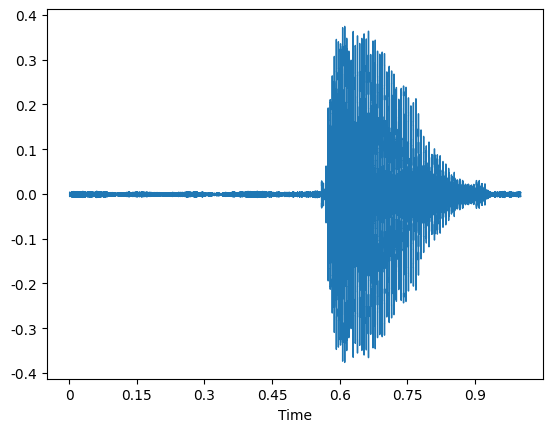

In [36]:
# 任選一檔案測試，發音為 go
train_audio_path = '/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/data/'
data, sr = librosa.load(train_audio_path+'/bed/004ae714_nohash_0.wav')

# 繪製波形
librosa.display.waveshow(data, sr=sr)
print(data.shape)

(22050,)


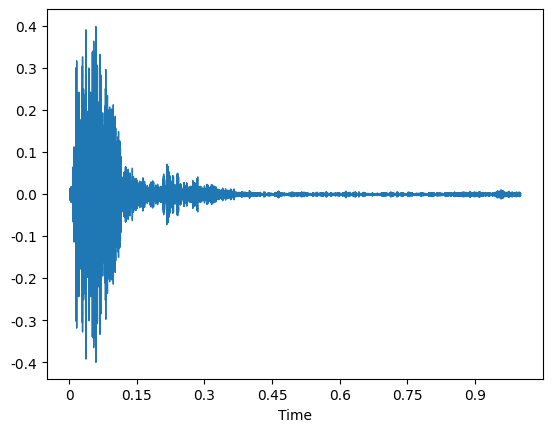

In [37]:
# 任選一檔案測試，發音為 left
train_audio_path = '/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/data'
data, sr = librosa.load(train_audio_path+'/happy/0135f3f2_nohash_0.wav')

# 繪製波形
librosa.display.waveshow(data, sr=sr)
print(data.shape)

In [38]:
# 播放
from IPython.display import Audio

Audio(data, rate=sr)

In [39]:
# 取得音檔的屬性
import wave

wav_file = train_audio_path+'/happy/0135f3f2_nohash_0.wav'
f=wave.open(wav_file)
print(f'取樣頻率={f.getframerate()}, 幀數={f.getnframes()}, ' +
      f'聲道={f.getnchannels()}, 精度={f.getsampwidth()}, ' +
      f'檔案秒數={f.getnframes() / f.getframerate():.2f}')
f.close()

nchannels2 = f.getnchannels()
sample_rate2 = f.getframerate()
sample_width2 = f.getsampwidth()

取樣頻率=16000, 幀數=16000, 聲道=1, 精度=2, 檔案秒數=1.00


In [41]:
# 重抽樣，統一取 8000 個樣本
wav_file = train_audio_path+'/happy/0135f3f2_nohash_0.wav'
samples, sample_rate = librosa.load(wav_file, sr=None, res_type='kaiser_fast')
#samples, sample_rate = librosa.load('/content/drive/MyDrive/COLAB/Google Speech Commands Dataset_2/left/022cd682_nohash_1.wav')
print(f'original sample rate={sample_rate}')
print(f'幀數={len(samples)}')
# 重抽樣，統一取 8000 個樣本
#samples = librosa.resample(samples, sample_rate, 8000)
#print(f'幀數={len(samples)}')

original sample rate=16000
幀數=16000


In [42]:
samples, sample_rate = librosa.load(wav_file, sr=None, res_type='kaiser_fast')
print(f'original sample rate={sample_rate}')
print(f'幀數={len(samples)}')
new_samples = np.pad(samples,(0, 16000-len(samples)),'constant')
print(f'幀數={len(new_samples)}')

original sample rate=16000
幀數=16000
幀數=16000


In [43]:
# 重抽樣另一個檔，統一取 8000 個樣本
wav_file = train_audio_path+'/happy/0135f3f2_nohash_0.wav'
samples, sample_rate = librosa.load(wav_file, sr=None, res_type='kaiser_fast')
print(f'original sample rate={sample_rate}')
print(f'幀數={len(samples)}')
# 重抽樣，統一取 8000 個樣本
#samples = librosa.resample(samples, sample_rate, 8000)
#print(f'幀數={len(samples)}')

original sample rate=16000
幀數=16000


In [44]:
samples[:100]

array([ 0.00036621,  0.00131226,  0.00363159,  0.00823975,  0.01266479,
        0.01342773,  0.00949097,  0.00259399, -0.00195312, -0.00091553,
        0.00335693,  0.00686646,  0.0071106 ,  0.00445557,  0.00091553,
       -0.00283813, -0.00762939, -0.01208496, -0.01321411, -0.01095581,
       -0.00726318, -0.00454712, -0.00363159, -0.00183105,  0.00177002,
        0.00460815,  0.00509644,  0.00323486,  0.00100708,  0.0012207 ,
        0.00344849,  0.00588989,  0.00747681,  0.00698853,  0.00387573,
       -0.00097656, -0.00616455, -0.00976562, -0.01052856, -0.01037598,
       -0.01153564, -0.01364136, -0.01477051, -0.01278687, -0.00848389,
       -0.00515747, -0.00366211, -0.00289917, -0.00164795,  0.00177002,
        0.00726318,  0.01293945,  0.01730347,  0.01864624,  0.01647949,
        0.01242065,  0.00863647,  0.00637817,  0.00457764,  0.0015564 ,
       -0.00289917, -0.00726318, -0.01043701, -0.01211548, -0.01272583,
       -0.01416016, -0.01672363, -0.01834106, -0.01763916, -0.01

In [45]:
# 取得子目錄名稱
labels=os.listdir(train_audio_path)
labels

['cat', 'bed', 'happy']

檔案數=[1733, 1713, 1742]


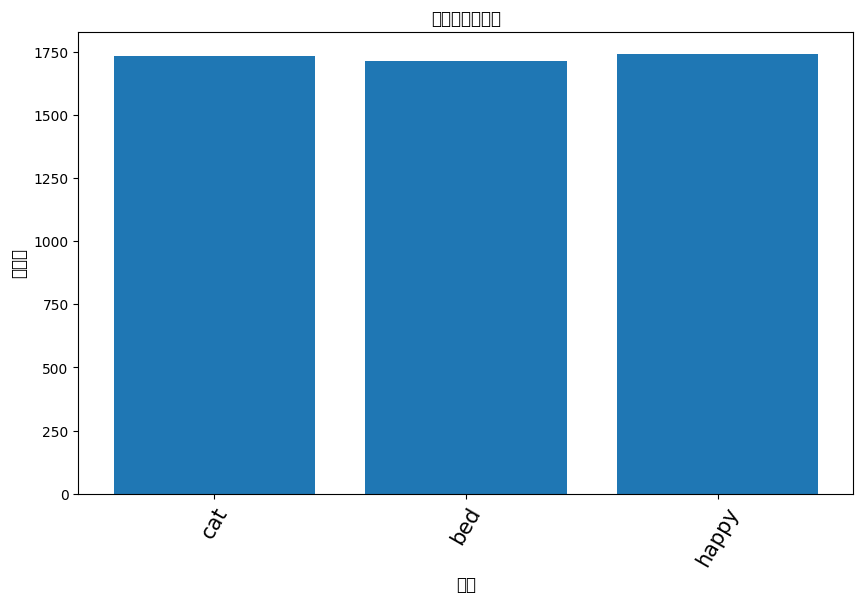

In [46]:
# 子目錄的檔案數
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path+ '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# 繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,6))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('指令', fontsize=12)
plt.ylabel('檔案數', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('子目錄的檔案數')
print(f'檔案數={no_of_recordings}')
plt.show()

(1733, 16000)
(1713, 16000)
(1742, 16000)


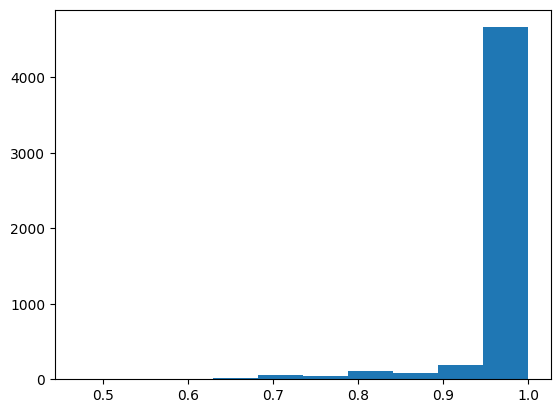

In [48]:
# 載入音樂檔案
TOTAL_FRAME_COUNT = 16000 # 每個檔案統一的幀數
duration_of_recordings=[]
all_wave = []
y = []
for i, label in enumerate(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    class_wave=None
    for wav in waves:
        # 載入音樂檔案
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav
                                            ,sr=None , res_type='kaiser_fast')
        duration_of_recordings.append(float(len(samples)/sample_rate))
        # 長度不足，右邊補 0 (重抽樣,或去頭去尾)
        if len(samples) < TOTAL_FRAME_COUNT : 
            samples = np.pad(samples,(0, TOTAL_FRAME_COUNT-len(samples)),'constant')
        elif len(samples) > TOTAL_FRAME_COUNT : 
            samples = np.resize(samples, TOTAL_FRAME_COUNT)
            
        if class_wave is None:
            class_wave = samples.reshape(1, -1) 
        else:
            class_wave = np.concatenate([class_wave, samples.reshape(1, -1)], axis=0)
        y.append(i)
        
    all_wave.append(class_wave)    
    print(class_wave.shape)
    np.save('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset' + label + '.npy', class_wave) # 存成 npy
fig = plt.hist(np.array(duration_of_recordings))

In [49]:
# DEBUG Version, 載入音樂檔案
# TOTAL_FRAME_COUNT = 16000 # 每個檔案統一的幀數
# duration_of_recordings=[]
# all_wave = []
# y = []
# good_count_array=[]
# for i, label in enumerate(labels):
#     waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
#     class_wave=None
#     good_count=0
#     for wav in waves:
#         samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav
#                                             ,sr=None , res_type='kaiser_fast')
#         duration_of_recordings.append(float(len(samples)/sample_rate))
#         # 重抽樣，統一取 16000 個樣本
#         # samples = librosa.resample(samples, sample_rate, 8000)
#         if len(samples) < TOTAL_FRAME_COUNT : 
#             samples = np.pad(samples,(0, TOTAL_FRAME_COUNT-len(samples)),'constant')
#         elif len(samples) > TOTAL_FRAME_COUNT : 
#             samples = np.resize(samples, TOTAL_FRAME_COUNT)
#         if len(samples) != TOTAL_FRAME_COUNT : 
#             continue
#         else:
#             good_count+=1
            
#         if class_wave is None:
#             class_wave = samples.reshape(1, -1) 
#         else:
#             class_wave = np.concatenate([class_wave, samples.reshape(1, -1)], axis=0)
#         y.append(i)
        
#     good_count_array.append(good_count)    
#     all_wave.append(class_wave)
#     # 存成 npy
#     print(class_wave.shape)
#     np.save('./GoogleSpeechCommandsDataset/' + label + '.npy', class_wave)
# print(good_count_array)            
# fig = plt.hist(np.array(duration_of_recordings))

In [50]:
y[:10], y[-10:]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [51]:
len(all_wave)

3

In [52]:
# 載入npy檔案
train_audio_path2 = '/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset'
npy_files = [f for f in os.listdir(train_audio_path2) if f.endswith('.npy')]
print(npy_files)
all_wave = []
y = []
no=0
for i, label in enumerate(npy_files):
    class_wave = np.load(train_audio_path2+label)
    all_wave.append(class_wave)
    print(class_wave.shape)
    no+=class_wave.shape[0]
    y.extend(np.full(class_wave.shape[0], i))   

['cat.npy', 'bed.npy', 'happy.npy']
(1733, 16000)
(1713, 16000)
(1742, 16000)


In [53]:
# 標準化
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# for i in range(len(all_wave)):
#     all_wave[i] = scaler.fit_transform(all_wave[i])

In [54]:
# 計算 MFCC
MFCC_COUNT = 40
X = None
for class_wave in all_wave:
    for data in class_wave:
        mfcc = librosa.feature.mfcc(y=data, sr=len(data), n_mfcc=MFCC_COUNT)
        # print(data.shape, mfcc.shape)
        if X is None:
            X = mfcc.reshape(1, MFCC_COUNT, -1, 1)
        else:
            X = np.concatenate((X, mfcc.reshape(1, MFCC_COUNT, -1, 1)), axis=0)
    print(X.shape) 
print(X.shape, len(y))

(1733, 40, 32, 1)
(3446, 40, 32, 1)
(5188, 40, 32, 1)
(5188, 40, 32, 1) 5188


In [55]:
np.save('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/mfcc/mfcc.npy', X)
np.save('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/mfcc/y.npy', y)

In [56]:
X = np.load('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/mfcc/mfcc.npy')
y = np.load('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/mfcc/y.npy')
X.shape, y.shape
#5188 是筆數

((5188, 40, 32, 1), (5188,))

In [57]:
# 資料切割
from sklearn.model_selection import train_test_split
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape

((4150, 40, 32, 1), (1038, 40, 32, 1))

In [58]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(labels), activation="softmax"),
    ]
)

In [59]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型訓練
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# 評分(Score Model)
score=model.evaluate(X_test, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

Epoch 1/20
104/104 [==============================] - 11s 8ms/step - loss: 1.6117 - accuracy: 0.5928 - val_loss: 0.4911 - val_accuracy: 0.8181
Epoch 2/20
104/104 [==============================] - 0s 4ms/step - loss: 0.5143 - accuracy: 0.7934 - val_loss: 0.3273 - val_accuracy: 0.9048
Epoch 3/20
104/104 [==============================] - 0s 4ms/step - loss: 0.3548 - accuracy: 0.8639 - val_loss: 0.2275 - val_accuracy: 0.9253
Epoch 4/20
104/104 [==============================] - 0s 4ms/step - loss: 0.2819 - accuracy: 0.8958 - val_loss: 0.2072 - val_accuracy: 0.9337
Epoch 5/20
104/104 [==============================] - 0s 4ms/step - loss: 0.2467 - accuracy: 0.9105 - val_loss: 0.1753 - val_accuracy: 0.9434
Epoch 6/20
104/104 [==============================] - 1s 6ms/step - loss: 0.2037 - accuracy: 0.9241 - val_loss: 0.1649 - val_accuracy: 0.9458
Epoch 7/20
104/104 [==============================] - 1s 5ms/step - loss: 0.1803 - accuracy: 0.9389 - val_loss: 0.1440 - val_accuracy: 0.9518
Epoch

## 準確率繪圖

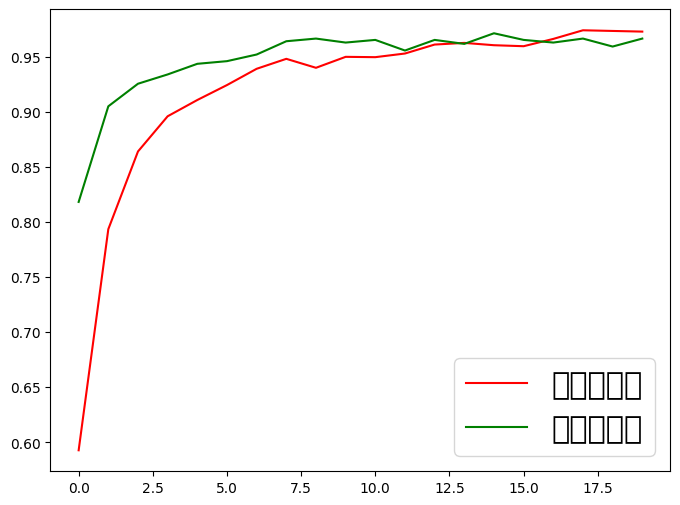

In [60]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
fig = plt.legend(prop={"size":22})

In [61]:
#模型存檔
model.save('./audio_model.h5')


In [62]:
#模型載入
model = tf.keras.models.load_model('/content/drive/MyDrive/COLAB/audio_model.h5')

In [72]:
# 預測函數
def predict(file_path):
    samples, sr = librosa.load(file_path, sr=None, res_type='kaiser_fast')
    # 繪製波形
    librosa.display.waveshow(samples)
    plt.show()
    
    # 右邊補 0
    if len(samples) < TOTAL_FRAME_COUNT : 
        samples = np.pad(samples,(0, TOTAL_FRAME_COUNT-len(samples)),'constant')
    elif len(samples) > TOTAL_FRAME_COUNT : 
        # 取中間一段
        oversize = len(samples) - TOTAL_FRAME_COUNT
        samples = samples[int(oversize/2):int(oversize/2)+TOTAL_FRAME_COUNT]

    # 繪製波形
    librosa.display.waveshow(samples)
    plt.show()

    # 驗證 mfcc 是否需要標準化
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=MFCC_COUNT)
    for i in range(mfcc.shape[1]):
        plt.scatter(x=range(mfcc.shape[0]), y=mfcc[:, i].reshape(-1))
    X_pred = mfcc.reshape(1, *mfcc.shape, 1)
    
    print(X_pred.shape, samples.shape)
    # 預測
    prob = model.predict(X_pred)
    return np.around(prob, 2), labels[np.argmax(prob)]

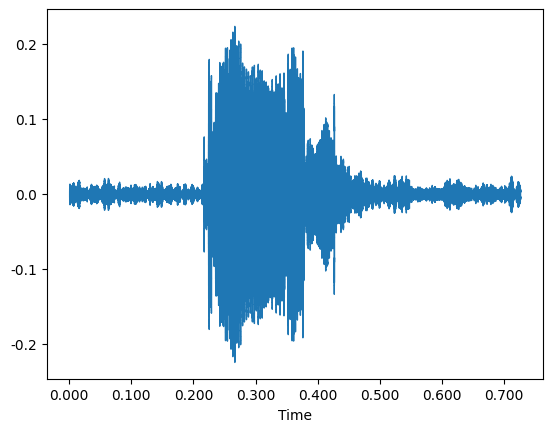

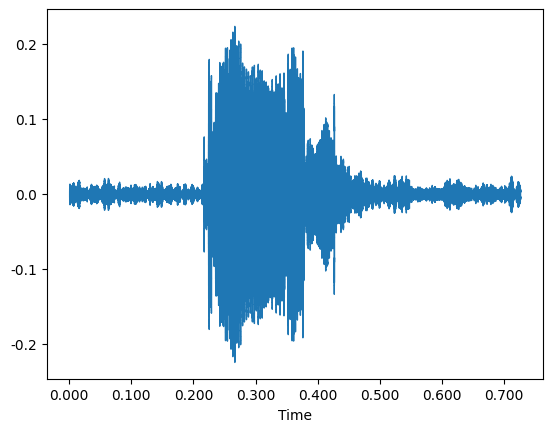

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 198ms/step


(array([[1., 0., 0.]], dtype=float32), 'cat')

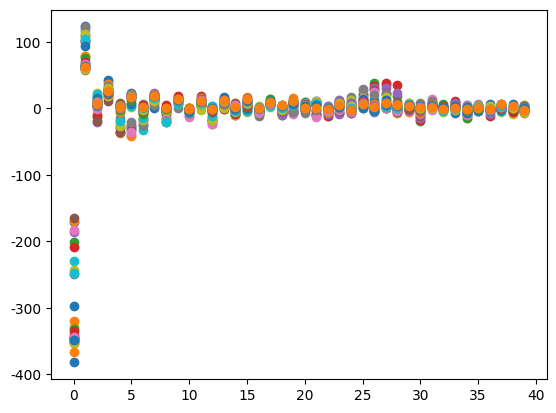

In [73]:
# 任選一檔案測試，該檔案發音為 bed
# 計算 MFCC
MFCC_COUNT = 40
train_audio_path = '/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/data/'
predict(train_audio_path+'/bed/0d2bcf9d_nohash_0.wav')

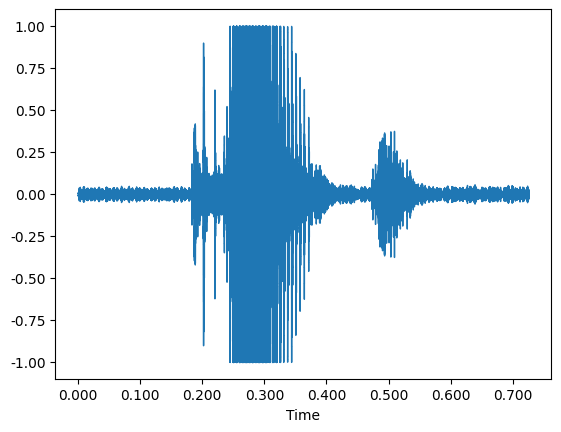

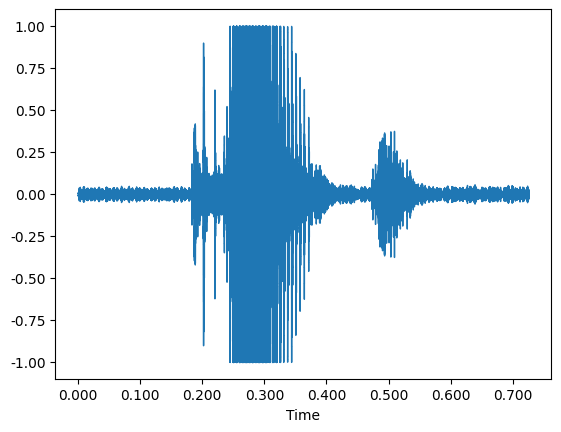

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 18ms/step


(array([[0., 1., 0.]], dtype=float32), 'bed')

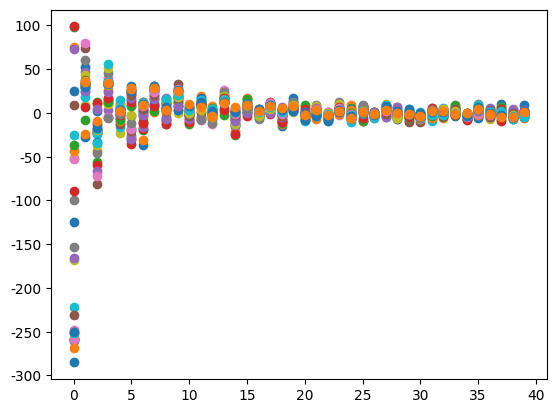

In [74]:
# 任選一檔案測試，該檔案發音為 cat
predict(train_audio_path+'/cat/0ac15fe9_nohash_0.wav')

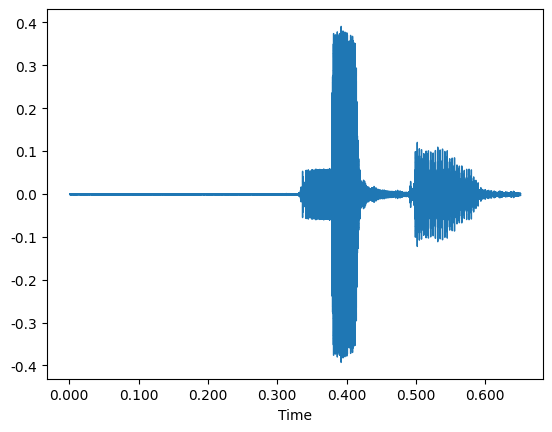

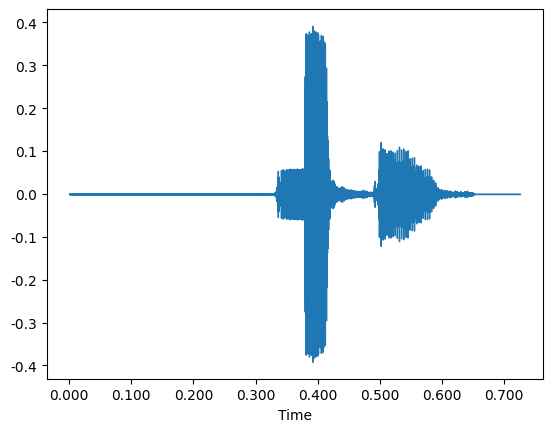

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 55ms/step


(array([[0., 0., 1.]], dtype=float32), 'happy')

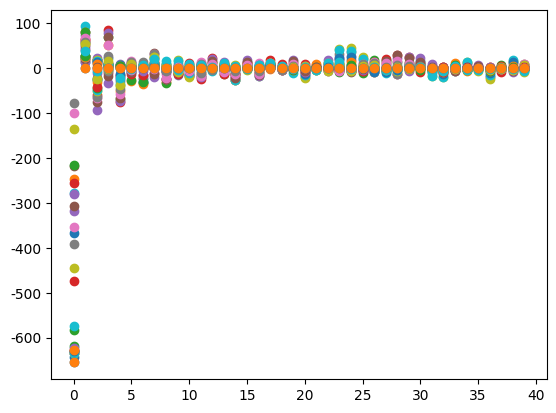

In [75]:
# 任選一檔案測試，該檔案發音為 happy
predict(train_audio_path+'happy/0ab3b47d_nohash_0.wav')

## 自行使用 14_10_record.py 錄音，指令：
python 14_10_record.py GoogleSpeechCommandsDataset/happy.wav

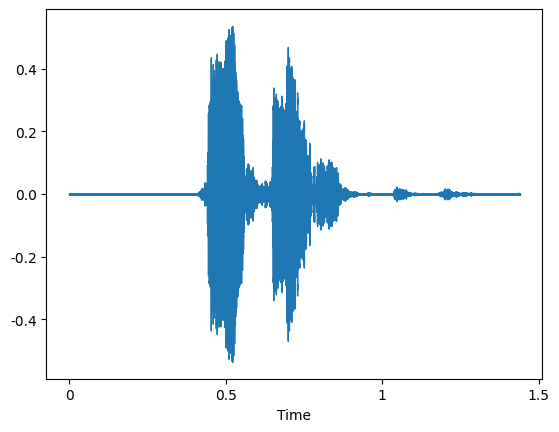

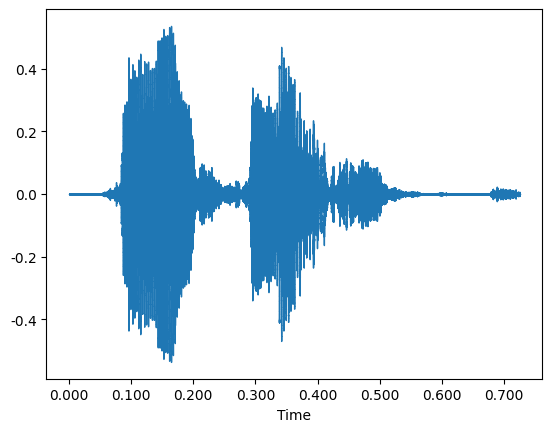

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 19ms/step


(array([[0., 0., 1.]], dtype=float32), 'happy')

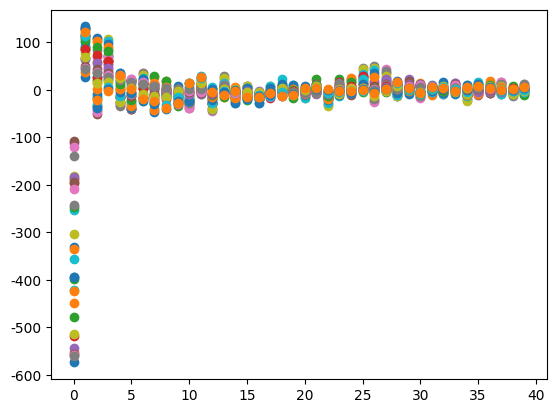

In [76]:
# 測試，該檔案發音為 happy
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/happy2.wav')

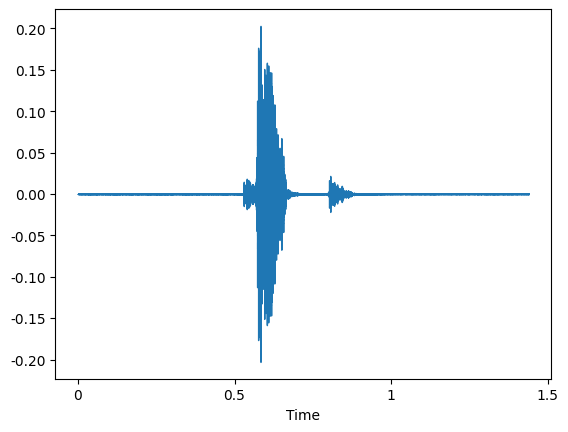

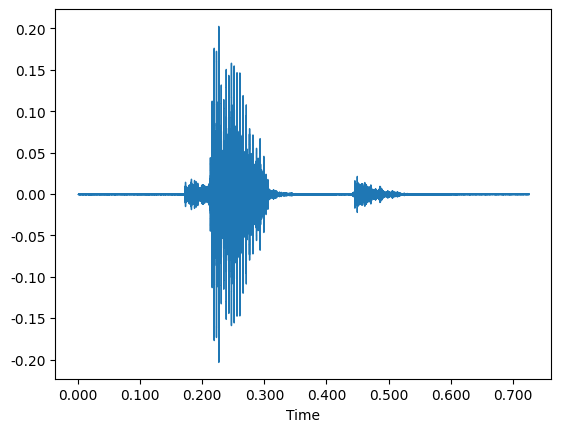

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 18ms/step


(array([[0.01, 0.68, 0.32]], dtype=float32), 'bed')

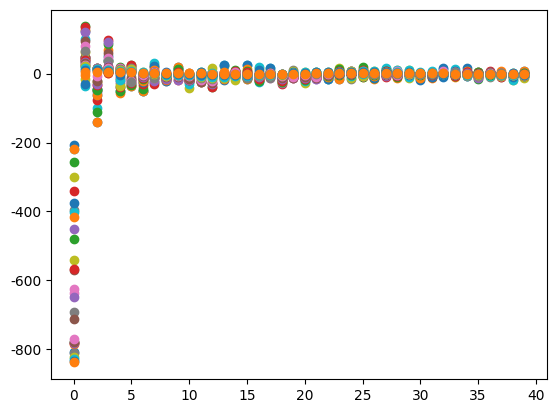

In [78]:
# 測試，該檔案發音為 cat
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/cat.wav')

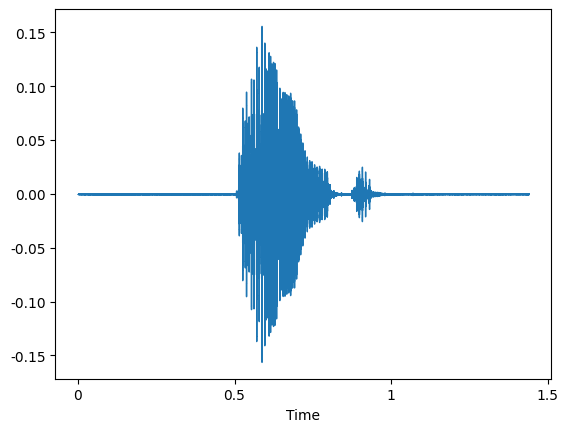

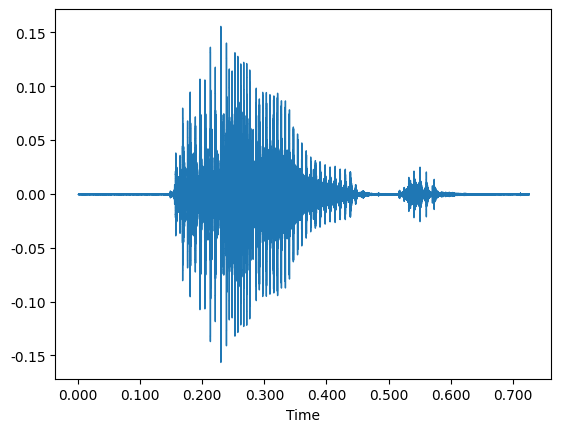

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 18ms/step


(array([[0.99, 0.  , 0.01]], dtype=float32), 'cat')

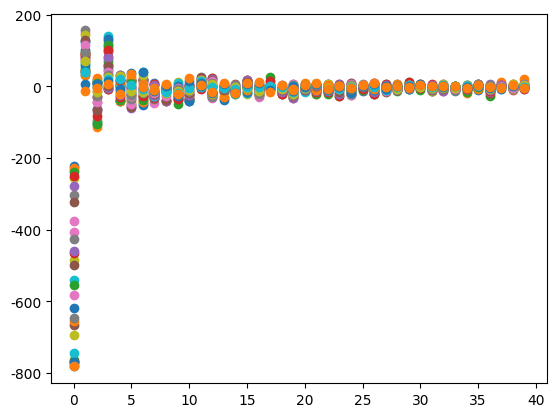

In [79]:
# 測試，該檔案發音為 bed
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/bed.wav')

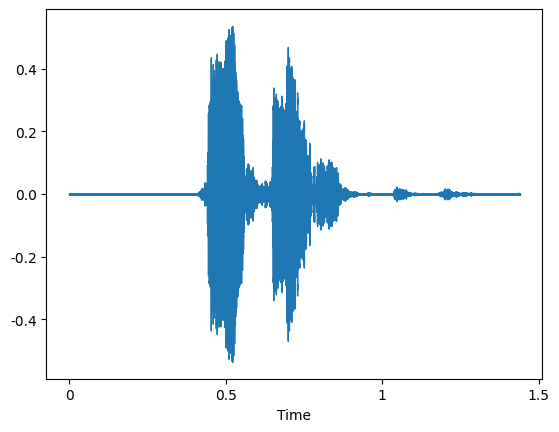

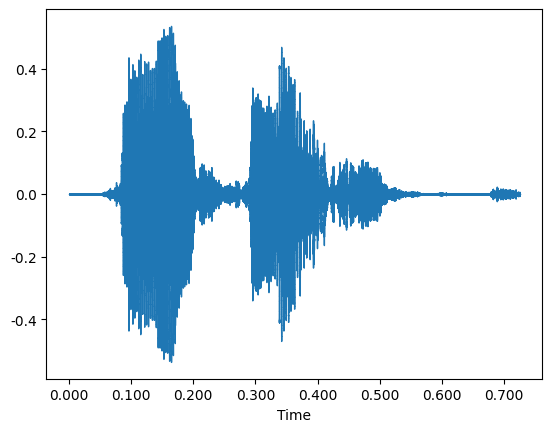

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 19ms/step


(array([[0., 0., 1.]], dtype=float32), 'happy')

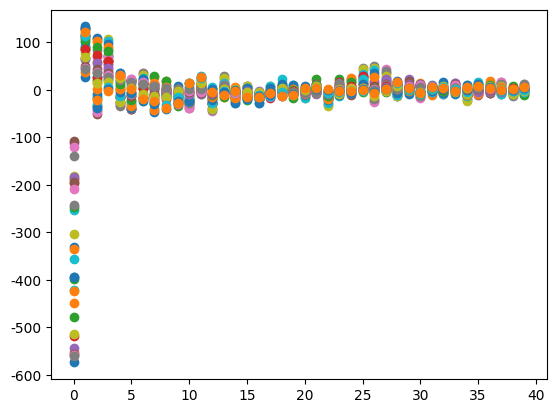

In [80]:
# 測試，該檔案發音為 happy
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/happy2.wav')

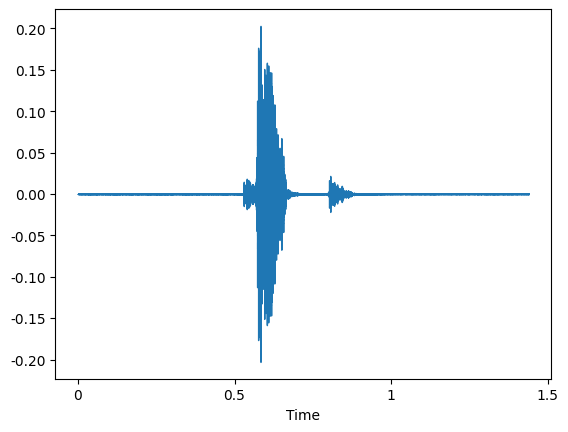

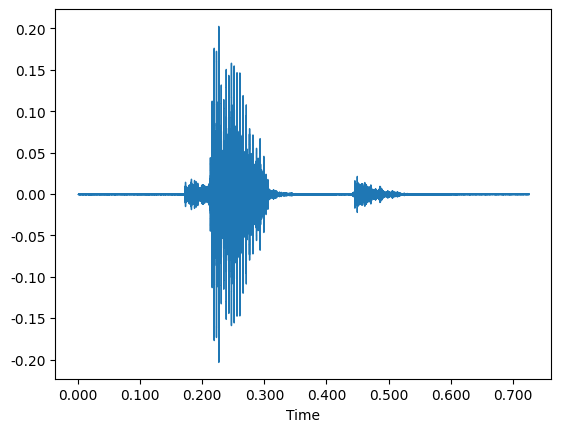

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 22ms/step


(array([[0.01, 0.68, 0.32]], dtype=float32), 'bed')

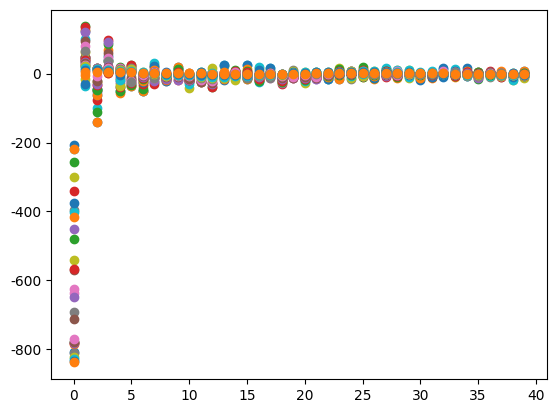

In [82]:
# 測試，該檔案發音為 cat
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/cat.wav')

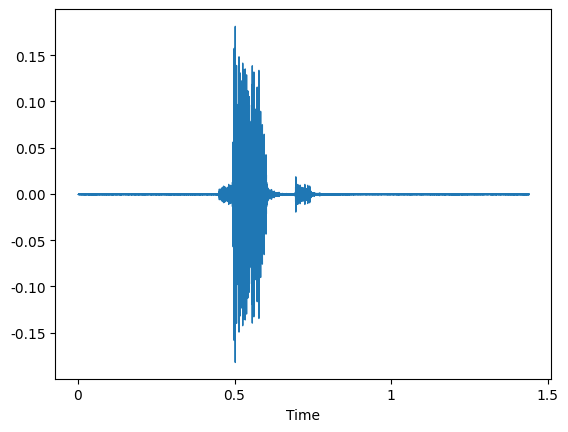

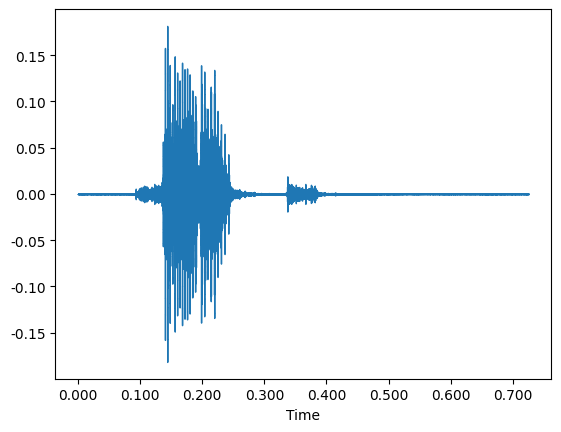

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 19ms/step


(array([[0.01, 0.77, 0.22]], dtype=float32), 'bed')

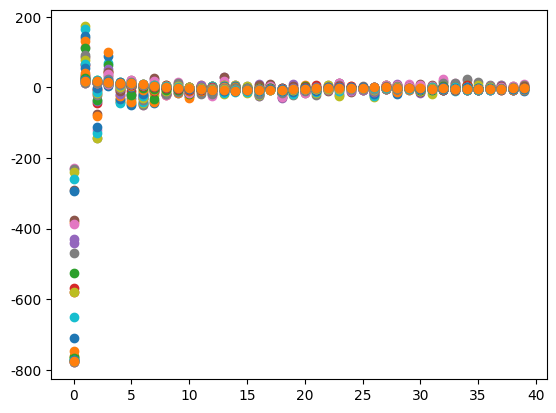

In [83]:
# 測試，該檔案發音為 cat
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/cat2.wav')

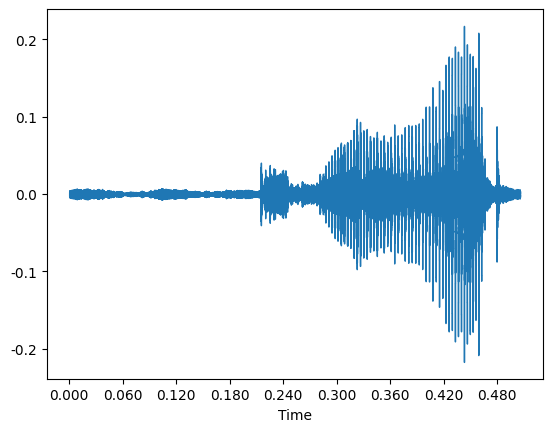

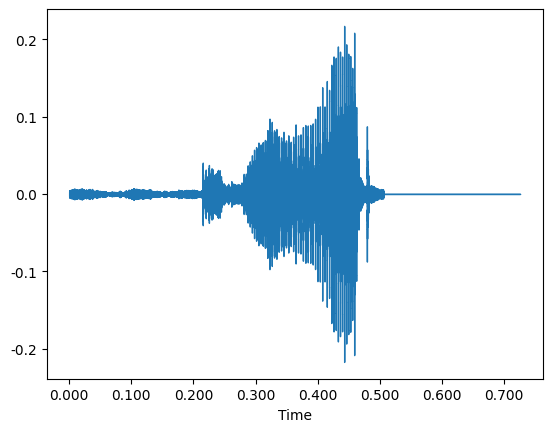

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 19ms/step


(array([[0., 1., 0.]], dtype=float32), 'bed')

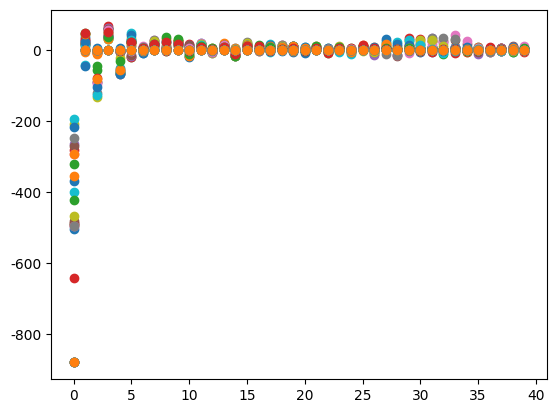

In [84]:
# 測試，該檔案發音為 cat
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/data/cat/004ae714_nohash_1.wav')

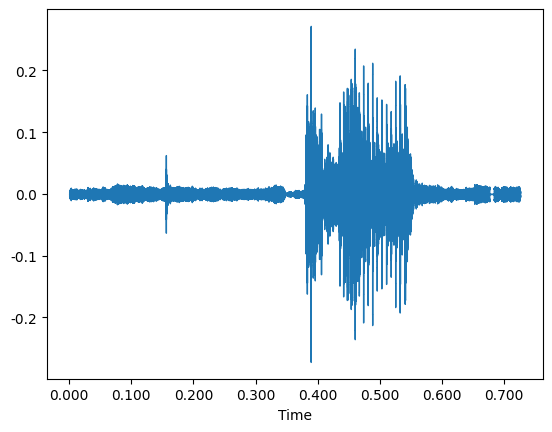

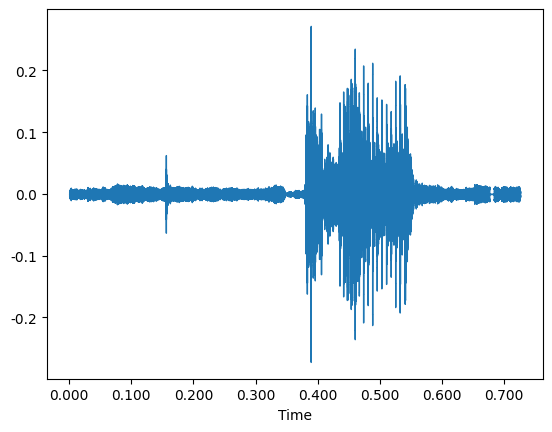

(1, 40, 32, 1) (16000,)
1/1 [==============================] - 0s 18ms/step


(array([[0., 1., 0.]], dtype=float32), 'bed')

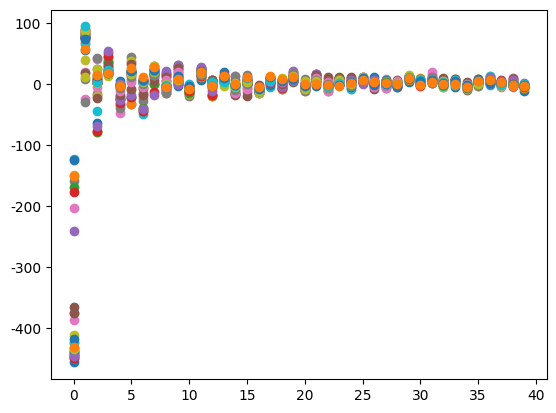

In [85]:
# 測試，該檔案發音為 cat
predict('/content/drive/MyDrive/COLAB/GoogleSpeechCommandsDataset/data/cat/012c8314_nohash_0.wav')